✅ Combined dataset shape: (43020, 687)
✅ Columns: ['hour_ts', 'start_station_name', 'start_station_id', 'ride_count', 'hour', 'hour_sin', 'hour_cos', 'day_of_week', 'is_holiday_or_weekend', 'month', 'is_peak_hour', 'day_of_year', 'time_of_day', 'ride_count_roll3', 'target_ride_count', 'ride_count_lag_1', 'ride_count_lag_2', 'ride_count_lag_3', 'ride_count_lag_4', 'ride_count_lag_5', 'ride_count_lag_6', 'ride_count_lag_7', 'ride_count_lag_8', 'ride_count_lag_9', 'ride_count_lag_10', 'ride_count_lag_11', 'ride_count_lag_12', 'ride_count_lag_13', 'ride_count_lag_14', 'ride_count_lag_15', 'ride_count_lag_16', 'ride_count_lag_17', 'ride_count_lag_18', 'ride_count_lag_19', 'ride_count_lag_20', 'ride_count_lag_21', 'ride_count_lag_22', 'ride_count_lag_23', 'ride_count_lag_24', 'ride_count_lag_25', 'ride_count_lag_26', 'ride_count_lag_27', 'ride_count_lag_28', 'ride_count_lag_29', 'ride_count_lag_30', 'ride_count_lag_31', 'ride_count_lag_32', 'ride_count_lag_33', 'ride_count_lag_34', 'ride_cou

C:\Users\MD\AppData\Local\Temp\ipykernel_2344\695694314.py:115: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MD\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


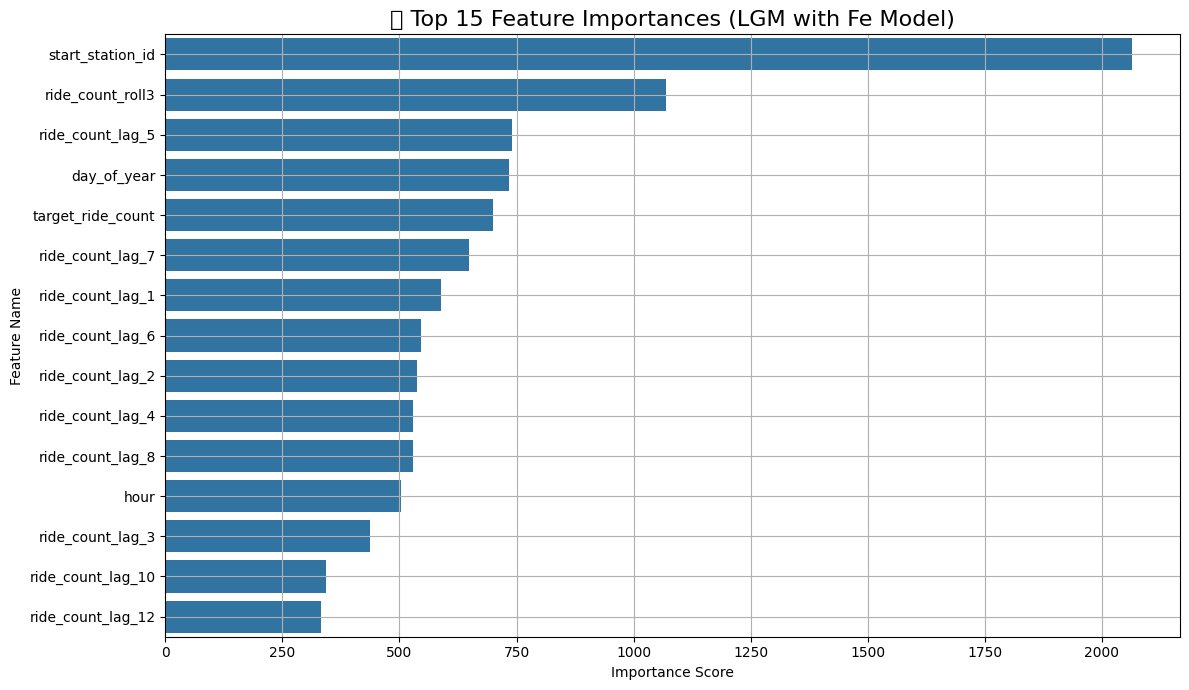

✅ Completed LGM with Fe with Manual Features!


In [2]:
# ==============================
# 📦 Imports
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.utils import split_time_series_data

# ==============================
# 📂 Load the final CitiBike dataset
# ==============================

final_features_path = Path("C:/Users/MD/Desktop/citi/data/processed/final_features")

df_2024 = pd.read_parquet(final_features_path / "rides_citibike_final_2024_with_lags.parquet")


df = pd.concat([df_2024]).reset_index(drop=True)

print(f"✅ Combined dataset shape: {df.shape}")
print(f"✅ Columns: {df.columns.tolist()}")

# ==============================
# ⏳ Manual Temporal Feature Engineering
# ==============================

# Extract date-based features from 'hour_ts'
df["day"] = df["hour_ts"].dt.day
df["week_of_year"] = df["hour_ts"].dt.isocalendar().week
df["quarter"] = df["hour_ts"].dt.quarter
df["is_start_of_month"] = (df["hour_ts"].dt.is_month_start).astype(int)
df["is_end_of_month"] = (df["hour_ts"].dt.is_month_end).astype(int)

print("✅ Manual temporal features added!")

# ==============================
# ✂️ Train-Test Split
# ==============================

# Split based on hour_ts
X_train, y_train, X_test, y_test = split_time_series_data(
    df,
    cutoff_date=datetime(2025, 1, 1),
    target_column="ride_count"
)

print(f"✅ Final X_train shape: {X_train.shape}")
print(f"✅ Final X_test shape: {X_test.shape}")

# ==============================
# 🚀 Train LightGBM Model
# ==============================

# Drop unnecessary columns for training
cols_to_drop = ["hour_ts", "start_station_name", "time_of_day"]
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

lgbmfe = LGBMRegressor(
    objective="regression",
    n_estimators=3000,         # ⏳ Train longer
    learning_rate=0.03,
    max_depth=8,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("🚀 Training Optimized LightGBM model...")
lgbmfe.fit(X_train, y_train)

# 🔮 Predict
y_pred_lgbm = lgbmfe.predict(X_test)

# ==============================
# 📊 Metrics
# ==============================

mae = mean_absolute_error(y_test, y_pred_lgbm)
mse = mean_squared_error(y_test, y_pred_lgbm)
rmse = mse ** 0.5

print(f"✅ LGM with Fe MAE: {mae:.2f}")
print(f"✅ LGM with Fe RMSE: {rmse:.2f}")

# ==============================
# 📈 Feature Importances
# ==============================

feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": lgbmfe.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(15))
plt.title("🚀 Top 15 Feature Importances (LGM with Fe Model)", fontsize=16)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Completed LGM with Fe with Manual Features!")


In [3]:
import mlflow
import dagshub
from dotenv import load_dotenv

# 🛠 Load environment variables
load_dotenv()

# 🛠 Initialize DagsHub MLflow connection (ONLY ONCE per session)
dagshub.init(repo_owner="duddukuntamaneesh", repo_name="citi", mlflow=True)

# 🧠 Start MLflow run to log LightGBM metrics
with mlflow.start_run(run_name="LightGBMFeatures"):
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)
    print("✅ LightGBM (manual features) MAE, MSE, RMSE logged to DagsHub successfully!")


Accessing as duddukuntamaneesh

Initialized MLflow to track repo "duddukuntamaneesh/citi"

Repository duddukuntamaneesh/citi initialized!

✅ LightGBM (manual features) MAE, MSE, RMSE logged to DagsHub successfully!
🏃 View run LightGBMFeatures at: https://dagshub.com/duddukuntamaneesh/citi.mlflow/#/experiments/0/runs/8ddd6a87301640f48a27db47cc9504ca
🧪 View experiment at: https://dagshub.com/duddukuntamaneesh/citi.mlflow/#/experiments/0
